In [241]:
from abc import ABC, abstractmethod
from dataclasses import dataclass
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict

In [242]:
DEBUG = False

# Strategies

In [243]:
# Abstract Class for Strategy.
class Strategy(ABC):
    @abstractmethod
    def move(self, own_history):
        pass

In [244]:
class ListRepeatedStrategy(Strategy):
    def __init__(self, moves=["C", "C", "D"]):
        self.moves = moves
        self.current_index = 0

    def move(self, own_history):
        move = self.moves[self.current_index]
        self.current_index = (self.current_index + 1) % len(self.moves)
        return move

In [245]:
# Naively faithful player (always chooses C)
class AlwaysCooperateStrategy(Strategy):
    def move(self, own_history):
        move = "C"
        return move

In [246]:
# Always chooses D
class AlwaysDefectStrategy(Strategy):
    def move(self, own_history):
        move = "D"
        return move

In [247]:
# Alternating choices between C and D
class AlternatingStrategy(Strategy):
    def move(self, own_history):
        if not own_history or own_history[-1] == "D":
            move = "C"
        else:
            move = "D"
        return move

In [248]:
class RandomStrategy(Strategy):
    def move(self, own_history):
        move = random.choice(["C", "D"])
        return move

In [249]:
class DeadStrategy(Strategy):
    def move(self, own_history):
        return None

# Strategy Switchers

In [250]:
class StrategySwitcher(ABC):
    @abstractmethod
    def check(self, agent, opponent):
        pass

In [251]:
class NOPSwitcher(StrategySwitcher):
    def check(self, agent, opponent):
        return False, None

In [252]:
# class UseMostCommonNeighborStrategy(StrategySwitcher):
#     def check(self, agent, opponent):
#         neighbor_strategies = [
#             neighbor.strategy.__class__ for neighbor in agent.neighbors
#         ]

#         strategy_counts = {}
#         for strategy in neighbor_strategies:
#             strategy_counts[strategy] = strategy_counts.get(strategy, 0) + 1

#         most_frequent_strategy = max(strategy_counts, key=strategy_counts.get)

#         if DEBUG:
#             print("Whole list: ", neighbor_strategies)
#             print("Most frequent: ", most_frequent_strategy)

#         # Dynamically instantiate the class based on the most frequent string
#         try:
#             return True, most_frequent_strategy()
#         except NameError:
#             print("Something wrong with my neighbors!")
#             return False, None

In [253]:
class SoftMajor(StrategySwitcher):
    def check(self, agent, opponent, threshold=0.5):
        assert agent.strategy.__class__.__name__ in [
            "AlwaysCooperateStrategy",
            "AlwaysDefectStrategy",
        ]
        opponent_tally = agent.gather_opponent_tally(opponent)
        opponent_cooperation_rate = opponent_tally.get_cooperation_rate()

        if opponent_cooperation_rate > threshold and agent.strategy.__class__.__name__ != "AlwaysCooperateStrategy":
            return True, AlwaysCooperateStrategy()
        elif opponent_cooperation_rate < threshold and agent.strategy.__class__.__name__ != "AlwaysDefectStrategy":
            return True, AlwaysDefectStrategy()
        return False, None

In [254]:
class AdaptiveSwitcher(StrategySwitcher):
    def check(self, agent, opponent):
        assert agent.strategy.__class__.__name__ in [
            "AlwaysCooperateStrategy",
            "AlwaysDefectStrategy",
        ]
        opponent_tally = agent.gather_opponent_tally(opponent)
        opponent_cooperation_rate = opponent_tally.get_cooperation_rate()

        # TODO: Where do these constants come from?
        reward_C = opponent_cooperation_rate * 3 + (1 - opponent_cooperation_rate) * 0
        reward_D = opponent_cooperation_rate * 5 + (1 - opponent_cooperation_rate) * 1

        if reward_C > reward_D and agent.strategy.__class__.__name__ != "AlwaysCooperateStrategy":
            return True, AlwaysCooperateStrategy()
        elif reward_C < reward_D and agent.strategy.__class__.__name__ != "AlwaysDefectStrategy":
            return True, AlwaysDefectStrategy()

        return False, None

In [255]:
class RandomSwitcher(StrategySwitcher):
    def check(self, agent, opponent):
        # TODO: Maybe we do not want ListRepeatedStrategy to be a possible
        #   strategy. It was made to test StrategySwitchers, not as a plausible
        #   strategy.
        # TODO: If you really do not want AlternatingStrategy, I think we should
        #   rather filter it out explicitly instead of manually listing all the
        #   strategies we want.
        pool_of_strats = Strategy.__subclasses__()
        pool_of_strats.remove(DeadStrategy)
        return True, random.choice(pool_of_strats)()

In [256]:
class TitForTat(StrategySwitcher):
    def check(self, agent, opponent):
        # opponent_history = opponent.history
        opponent_history = agent.opponent_histories[opponent.id]
        if DEBUG:
            print(
                f"Agent {agent.id} has strategy {agent.strategy.__class__.__name__} and switcher {self.__class__.__name__}"
            )
        assert agent.strategy.__class__.__name__ in [
            "AlwaysCooperateStrategy",
            "AlwaysDefectStrategy",
        ]

        if (
            opponent_history
            and opponent_history[-1] == "D"
            and agent.strategy.__class__.__name__ == "AlwaysCooperateStrategy"
        ):
            return True, AlwaysDefectStrategy()
        elif (
            opponent_history
            and opponent_history[-1] == "C"
            and agent.strategy.__class__.__name__ == "AlwaysDefectStrategy"
        ):
            return True, AlwaysCooperateStrategy()

        return False, None

In [257]:
class CooperateUntilNDefectionsInARow(StrategySwitcher):
    def __init__(self, n_defections_threshold=2):
        self.n_defections_threshold = n_defections_threshold
        self.n_defections_in_a_row = 0
        self.threshold_hit = False

    def check(self, agent, opponent):
        # opponent_history = opponent.history
        opponent_history = agent.opponent_histories[opponent.id]
        if DEBUG:
            print(
                f"Agent {agent.id} has strategy {agent.strategy.__class__.__name__} and switcher {self.__class__.__name__}"
            )

        assert agent.strategy.__class__.__name__ in [
            "AlwaysCooperateStrategy",
            "AlwaysDefectStrategy",
        ]
        assert self.n_defections_in_a_row >= 0

        if opponent_history and opponent_history[-1] == "D":
            self.n_defections_in_a_row += 1
        else:
            self.n_defections_in_a_row = 0

        if (
            not self.threshold_hit
            and self.n_defections_in_a_row >= self.n_defections_threshold
        ):
            self.threshold_hit = True

        if (
            agent.strategy.__class__.__name__ == "AlwaysCooperateStrategy"
            and self.threshold_hit
        ):
            return True, AlwaysDefectStrategy()

        return False, None

In [258]:
class RetaliateWithTwoDefections(StrategySwitcher):
    def __init__(self):
        self.retaliations_left = 0
        super().__init__()

    def check(self, agent, opponent):
        # opponent_history = opponent.history
        opponent_history = agent.opponent_histories[opponent.id]
        if DEBUG:
            print(
                f"Agent {agent.id} has strategy {agent.strategy.__class__.__name__} and switcher {self.__class__.__name__}"
            )

        assert agent.strategy.__class__.__name__ in [
            "AlwaysCooperateStrategy",
            "AlwaysDefectStrategy",
        ]
        assert self.retaliations_left >= 0

        if self.retaliations_left > 0:
            self.retaliations_left -= 1

        if opponent_history and opponent_history[-1] == "D":
            self.retaliations_left += 2

        if (
            self.retaliations_left > 0
            and agent.strategy.__class__.__name__ == "AlwaysCooperateStrategy"
        ):
            return True, AlwaysDefectStrategy()
        elif (
            self.retaliations_left == 0
            and agent.strategy.__class__.__name__ == "AlwaysDefectStrategy"
        ):
            return True, AlwaysCooperateStrategy()

        return False, None

# Player

In [259]:
@dataclass
class PlayerMoveTally:
    cooperations: int = 0
    defections: int = 0

    def update(self, move):
        if move == "C":
            self.cooperations += 1
        elif move == "D":
            self.defections += 1
        else:
            raise ValueError(f"Move must be either 'C' or 'D', got {move}")

    def get_cooperation_rate(self):
        # Assume the best in people
        if self.cooperations + self.defections == 0:
            return 1

        return self.cooperations / (self.cooperations + self.defections)

    def __add__(self, other):
        return PlayerMoveTally(
            cooperations=self.cooperations + other.cooperations,
            defections=self.defections + other.defections,
        )

    def __str__(self):
        return f"Cooperations: {self.cooperations}, Defections: {self.defections}"

In [260]:
# Generic class for any Player (next block we shall define inherited classes with specific strategies)
class Player:
    def __init__(self, strategy, strategy_switcher, credit=0, neighbors=[]):
        self.history = []
        self.strategy = strategy
        self.strategy_switcher = strategy_switcher
        self.neighbors = []
        self.neighbor_tallies = {}
        self.neighbor_histories = {}
        self.credit = credit

        self.add_neighbors(neighbors)

    def add_neighbors(self, neighbors):
        assert isinstance(
            neighbors, list
        ), f"Expected a list of neighbors, got {type(neighbors)}"

        for neighbor in neighbors:
            if neighbor not in self.neighbors:
                self.neighbors.append(neighbor)
                self.neighbor_tallies[neighbor.id] = PlayerMoveTally()
                self.neighbor_histories[neighbor.id] = []

    def set_credit(self, credit):
        self.credit = credit

    def gather_opponent_tally(self, opponent):
        opponent_tally = self.neighbor_tallies.get(opponent.id, PlayerMoveTally())

        if DEBUG:
            print(f"Player {self.id} gathering opponent tally for {opponent.id}")
            print(f"Knows '{opponent_tally}' so far")

        for neighbor in self.neighbors:
            if neighbor.id == opponent.id:
                continue

            neighbor_info = neighbor.neighbor_tallies.get(
                opponent.id, PlayerMoveTally()
            )
            opponent_tally += neighbor_info

            if DEBUG:
                print(f"\tGot '{neighbor_info}' from {neighbor.id}")
                print(f"\tUpdated tally to '{opponent_tally}'")

        return opponent_tally

    def update_tally(self, opponent, opponent_move):
        self.neighbor_tallies[opponent.id].update(opponent_move)
        self.neighbor_histories[opponent.id].append(opponent_move)

    def check_should_switch_strategy(self, opponent):
        should_switch_strategy, next_strategy = self.strategy_switcher.check(
            self, opponent
        )
        if should_switch_strategy:
            self._switch_strategy(next_strategy)

    def play(self, opponent):
        decision = self.strategy.move(self.history)
        self.update_history(decision)
        return decision

    def update_history(self, own_move):
        self.history.append(own_move)

    def update_credit(self, addend):
        self.credit += addend
        if self.is_dead():
            self.strategy = DeadStrategy()

    def is_dead(self):
        return self.credit <= 0

    def latest_move(self):
        return self.history[-1]

    def _switch_strategy(self, new_strategy):
        self.strategy = new_strategy

# Helper Functions

In [261]:
# Define a typical Prisoner's Dilemma payoff matrix
PAYOFF_MATRIX = {
    'C': {'C': (3, 3), 'D': (0, 5)},
    'D': {'C': (5, 0), 'D': (1, 1)}
}

# Network Generator

In [262]:
@dataclass
class Edge:
    x1: int
    y1: int
    x2: int
    y2: int

    @classmethod
    def from_indices(cls, index1, index2, width):
        x1, y1 = index1 // width, index1 % width
        x2, y2 = index2 // width, index2 % width
        return cls(x1, y1, x2, y2)

    def __str__(self):
        return f"({self.x1}, {self.y1}) -> ({self.x2}, {self.y2})"

In [263]:
@dataclass
class NetworkPosition:
    x: int
    y: int

    @classmethod
    def from_index(cls, index, width):
        return cls(index // width, index % width)

    def to_index(self, width):
        return self.x * width + self.y

    def __str__(self):
        return f"({self.x}, {self.y})"

In [264]:
class Network:
    def __init__(self, N, M, Ntype="Lattice", density=0, spread=0):
        assert Ntype in ["Graph", "Lattice", "CLattice"]
        self.dim = (N, M)
        self.sz = N * M
        self.type = Ntype
        self.density = density
        self.spread = spread

    def generate(self):
        self.l = [[0 for _ in range(self.sz)] for _ in range(self.sz)]
        self.edges = []

        if self.type == "Graph":
            e = int((self.sz * self.sz - self.sz) * self.density / 2)
            assert e > 0

            random.seed(int(self.sz * e / 4))

            cnt = 0
            while cnt < e:
                edj = random.randrange(0, self.sz * self.sz)
                u, v = edj % self.sz, edj // self.sz
                if u == v or self.l[u][v] > 0:
                    continue
                self.l[u][v] = self.l[v][u] = 1
                cnt = cnt + 1

        elif self.type == "Lattice":
            for i in range(0, self.dim[0]):
                for j in range(0, self.dim[1]):
                    if i > 0:
                        self.l[i * self.dim[1] + j][(i - 1) * self.dim[1] + j] = 1
                    if i < self.dim[0] - 1:
                        self.l[i * self.dim[1] + j][(i + 1) * self.dim[1] + j] = 1
                    if j > 0:
                        self.l[i * self.dim[1] + j][i * self.dim[1] + j - 1] = 1
                    if j < self.dim[1] - 1:
                        self.l[i * self.dim[1] + j][i * self.dim[1] + j + 1] = 1

        elif self.type == "CLattice":
            for i in range(0, self.dim[0]):
                for j in range(0, self.dim[1]):
                    if i > 0:
                        self.l[i * self.dim[1] + j][(i - 1) * self.dim[1] + j] = 1
                    if i < self.dim[0] - 1:
                        self.l[i * self.dim[1] + j][(i + 1) * self.dim[1] + j] = 1
                    if j > 0:
                        self.l[i * self.dim[1] + j][i * self.dim[1] + j - 1] = 1
                    if j < self.dim[1] - 1:
                        self.l[i * self.dim[1] + j][i * self.dim[1] + j + 1] = 1

            e = int((self.sz * self.sz - self.sz) * self.density / 2)
            assert e > 0

            random.seed(int(self.sz * e / 4))

            cnt = 0
            while cnt < e:
                edj1 = random.randrange(0, self.sz)
                u1, v1 = edj1 // self.dim[1], edj1 % self.dim[1]
                u2, v2 = round(random.gauss(u1, self.spread)), round(
                    random.gauss(v1, self.spread)
                )
                if (
                    (u1 == u2 and v1 == v2)
                    or u2 < 0
                    or u2 >= self.dim[0]
                    or v2 < 0
                    or v2 >= self.dim[1]
                ):
                    continue
                edj2 = u2 * self.dim[1] + v2
                if self.l[edj1][edj2] > 0:
                    continue
                self.l[edj1][edj2] = self.l[edj2][edj1] = 1
                cnt = cnt + 1

        for i in range(self.sz):
            for j in range(i + 1, self.sz):
                if self.l[i][j]:
                    self.edges.append(Edge.from_indices(i, j, self.dim[1]))

        self.E = len(self.edges)

    def getEdges(self, from_position):
        eList = []
        for v in range(0, self.sz):
            if self.l[from_position.to_index(self.dim[1])][v] == 1:
                eList.append(NetworkPosition.from_index(v, self.dim[1]))

        return eList

    def printNet(self):
        print("|V| = " + str(self.sz) + "; |E| = " + str(self.E))
        for u in range(self.sz):
            at = NetworkPosition.from_index(u, self.dim[1])
            print(f"{at}: ", end="")
            lst = self.getEdges(at)
            for network_position in lst:
                print(f" {network_position}", end="")
            print()

In [265]:
net1 = Network(5, 5, "Lattice")
net1.generate()
# net1.printNet()
assert net1.E == 40

In [266]:
net2 = Network(5, 5, "Graph", density=0.25)
net2.generate()
# net2.printNet()
assert net2.E == 75

In [267]:
net3 = Network(5, 5, "CLattice", density=0.04, spread=5)
net3.generate()
# net3.printNet()
assert net3.E == 52

# Simulator

In [268]:
class SimulatorPlayer(Player):
    next_id = 0

    def __init__(self):
        self.id = SimulatorPlayer.next_id
        SimulatorPlayer.next_id += 1

        super().__init__(None, None)

    def init(self, neighbors, player):
        if DEBUG:
            print(f"Initializing player {self.id}")

        self.add_neighbors(neighbors)
        self.history = player.history
        self.strategy = player.strategy
        self.strategy_switcher = player.strategy_switcher
        self.set_credit(player.credit)

    def play(self, opponent):
        return super().play(opponent)

In [269]:
class Simulator:
    def __init__(self, n, m, pm=PAYOFF_MATRIX):
        self.n = n
        self.m = m
        self.payoff_matrix = pm
        self.population = []
        self.cooperation_percentage = []

    def init_network(self, ntype="Lattice", density=0.0, spread=0.0):
        self.network = Network(self.n, self.m, ntype, density, spread)
        self.network.generate()

    def init_grid(self):
        self.grid = []
        for i in range(self.n):
            self.grid.append([])
            for j in range(self.m):
                self.grid[i].append(SimulatorPlayer())
        self.pairs = [
            (self.grid[edge.x1][edge.y1], self.grid[edge.x2][edge.y2])
            for edge in self.network.edges
        ]

    def set_player(self, i, j, player):
        ngbr_list = self.network.getEdges(NetworkPosition(i, j))
        ngbrs = [
            self.grid[network_position.x][network_position.y]
            for network_position in ngbr_list
        ]
        self.grid[i][j].init(ngbrs, player)

    def match(self, p1: SimulatorPlayer, p2: SimulatorPlayer):
        if p1.is_dead() or p2.is_dead():
            return None
        move1 = p1.play(p2)
        move2 = p2.play(p1)

        p1.update_tally(p2, move2)
        p2.update_tally(p1, move1)

        p1.check_should_switch_strategy(p2)
        p2.check_should_switch_strategy(p1)

        score1, score2 = self.payoff_matrix[move1][move2]

        p1.update_credit(score1)
        p2.update_credit(score2)

        return score1, score2

    def round(self):
        scores = [[0 for _ in range(self.m)] for _ in range(self.n)]
        for i in range(len(self.pairs)):
            pair = self.pairs[i]
            edge = self.network.edges[i]
            try:
                score1, score2 = self.match(pair[0], pair[1])
                scores[edge.x1][edge.y1] += score1
                scores[edge.x2][edge.y2] += score2
            except:
                continue
        return scores

    def simulate(self, n_rounds=1):
        scores_history = []

        for _ in range(n_rounds):
            scores = self.round()
            scores_history.append(scores)
            self.population.append(self.count_strategies())

        return scores_history

    def count_strategies(self, strategy_classes=Strategy.__subclasses__()):
        strategy_counts = {
            name: 0 for name in [cls.__name__ for cls in strategy_classes]
        }

        agents = [agent for grid_line in self.grid for agent in grid_line]
        for agent in agents:
            for strategy_class in strategy_classes:
                if isinstance(agent.strategy, strategy_class):
                    strategy_counts[strategy_class.__name__] += 1
                    break

        return strategy_counts

    """
    TODO: Implementation of plot function for the simulation
    """

    def update_cooperation_rate(self, n_rounds):
        for round in range(n_rounds):
            round_strings = []

            for i in range(self.n):
                for j in range(self.m):
                    d = len(self.grid[i][j].history) / n_rounds
                    start = int(round * d)
                    end = int(start + d)
                    player_string = self.grid[i][j].history[start:end]
                    round_strings += player_string

            self.cooperation_percentage.append(round_strings)

    def plot_cooperation(self, n_rounds):
        self.update_cooperation_rate(n_rounds)
        # Step 1: Calculate percentages per time step
        percentages = []
        for sublist in self.cooperation_percentage:
            count_C = sublist.count("C")
            total_count = len(sublist)
            percentage_C = count_C / total_count if total_count > 0 else 0
            percentages.append(percentage_C)

        # Step 2: Plotting
        plt.figure(figsize=(10, 6))
        plt.plot(percentages)

        plt.xlabel("Virtual Time (rounds)")
        plt.ylabel("Percentage of Cooperation")
        plt.title("Percentage of Cooperation Over Time")
        # plt.xticks(range(len(self.cooperation_percentage)))
        plt.grid(True)
        plt.show()

    def plot_evolution(self):
        # Convert to DataFrame
        df = pd.DataFrame(self.population)

        # Filter out columns (strategies) where all values are zero
        df = df.loc[:, (df != 0).any(axis=0)]
    
        # Plotting
        plt.figure(figsize=(10, 6))
        for column in df.columns:
            plt.plot(df[column], label=column)
            # plt.plot(df.index, df[column], marker='o', label=column)

        plt.xlabel("Virtual Time (rounds)")
        plt.ylabel("Strategy Value")
        plt.title("Evolution of Strategies Over Time")
        # plt.xticks(range(len(df)))
        plt.legend()
        plt.grid(True)
        plt.show()
        return df

In [ ]:
pool_of_strats = Strategy.__subclasses__()
pool_of_strats.remove(DeadStrategy)
# NOTE: Some StrategySwitchers have default parameters we could play around with.
pool_of_switchers = StrategySwitcher.__subclasses__()

# Experiment 1: 
50-50 AllC and AllD strats randomly distributed. 
AllD players have SoftMajor switcher, AllC players have a random chance p of having NOPSiwtcher. 
Result: for p >= 0.1, all players eventually adopt AllC strategy.
Interpretation: small number of pure cooperative players lead to stable cooperation starting from symmetry 50-50.

In [371]:
# Setup experiment scale
grid_size = 50
num_rounds = 100

insist_percent = np.arange(0, 1 + 0.01, 0.05)
cooperate_dominance = np.zeros(len(insist_percent))
for k,p in enumerate(insist_percent):
    s = Simulator(grid_size, grid_size)
    s.init_network("Lattice")
    s.init_grid()
    for i in range(grid_size):
        for j in range(grid_size):
            chosen_strategy = random.choice([AlwaysCooperateStrategy, AlwaysDefectStrategy])
            if (chosen_strategy == AlwaysCooperateStrategy) and (random.random() < p):
                chosen_switcher = NOPSwitcher
            else:
                chosen_switcher = SoftMajor
            s.set_player(i, j, Player(chosen_strategy(), chosen_switcher()))

    s.simulate(n_rounds=num_rounds)
    cooperate_dominance[k] = s.count_strategies()['AlwaysCooperateStrategy']/\
            (s.count_strategies()['AlwaysDefectStrategy']+s.count_strategies()['AlwaysCooperateStrategy'])


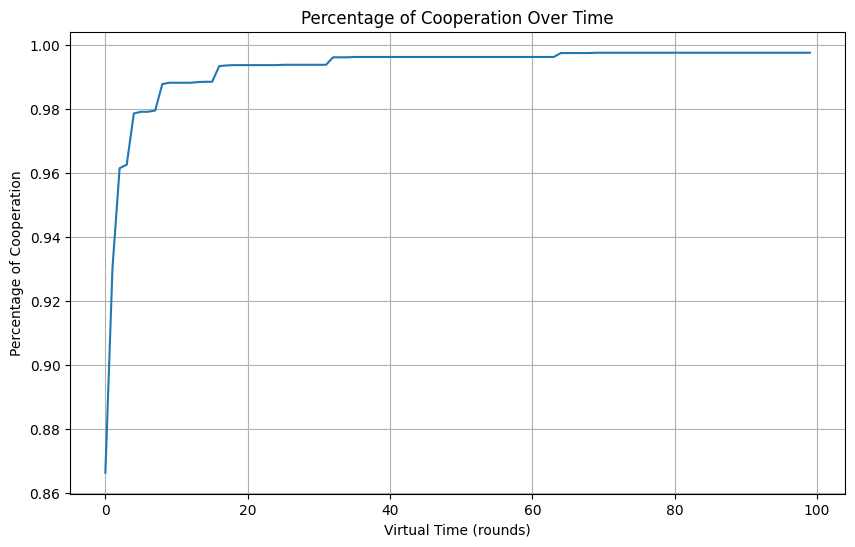

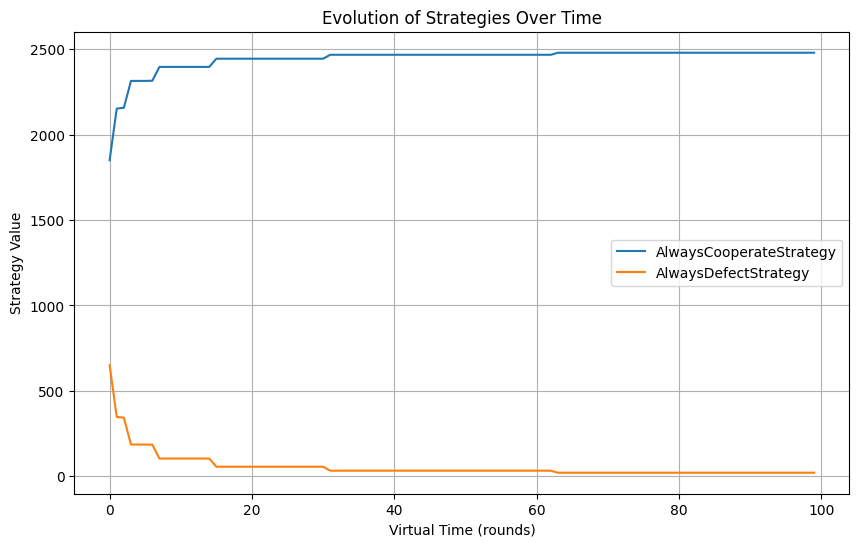

Text(0.5, 1.0, 'Small number of pure cooperative players can invade all')

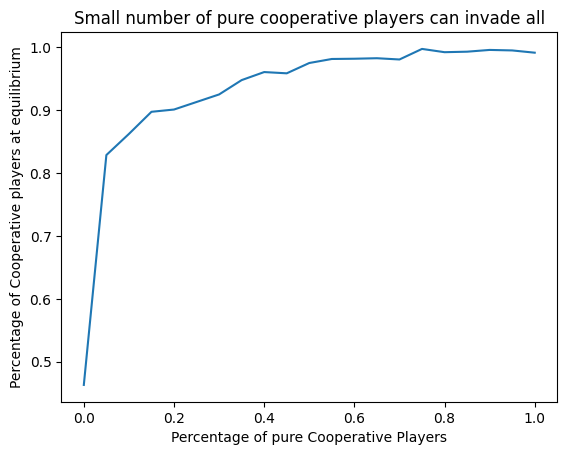

In [372]:
s.plot_cooperation(num_rounds)
dff = s.plot_evolution()

plt.plot(insist_percent, cooperate_dominance)
plt.xlabel('Percentage of pure Cooperative Players')
plt.ylabel('Percentage of Cooperative players at equilibrium')
plt.title('Small number of pure cooperative players can invade all')

# Experiment 2
50-50 AllC and AllD strats randomly distributed. 
All players have SoftMajor switcher.
Result: eventually the numbers of AllC and AllD players saturate, around values around 0.5 (this depends on the distribution) -> so is the cooperation rate.
Interpretation: everyone mimics their neighbors will lead to random equilibrium around 0.5.

In [364]:
grid_size = 50
num_rounds = 100

iterations = 20
cooperate_dominance = np.zeros(iterations)
for k in range(iterations):
    s = Simulator(grid_size, grid_size)
    s.init_network("Lattice")
    s.init_grid()
    for i in range(grid_size):
        for j in range(grid_size):
            chosen_strategy = random.choice([AlwaysCooperateStrategy, AlwaysDefectStrategy])
            chosen_switcher = SoftMajor
            s.set_player(i, j, Player(chosen_strategy(), chosen_switcher()))

    s.simulate(n_rounds=num_rounds)    
    cooperate_dominance[k] = s.count_strategies()['AlwaysCooperateStrategy']/\
            (s.count_strategies()['AlwaysDefectStrategy']+s.count_strategies()['AlwaysCooperateStrategy'])

Text(0.5, 1.0, 'SoftMajor leads to random equilibrium around 50-50')

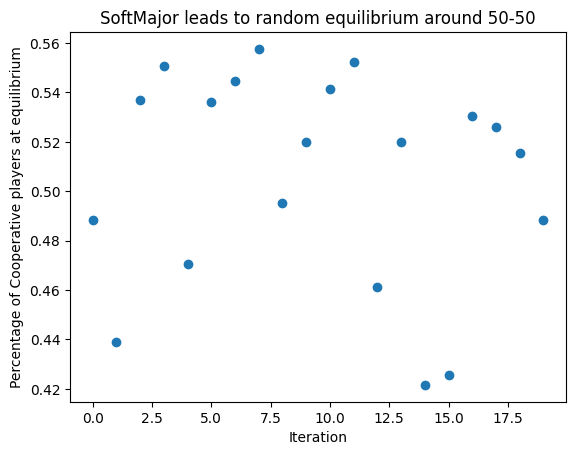

In [366]:
# s.plot_cooperation(num_rounds)
# dff = s.plot_evolution()

plt.scatter(np.arange(0,len(cooperate_dominance),1),cooperate_dominance)
plt.xlabel('Iteration')
plt.ylabel('Percentage of Cooperative players at equilibrium')
plt.title('SoftMajor leads to random equilibrium around 50-50')

# Experiment 3
Start with all players cooperating (allC) except a few n_defect random allD.
All players adopt CooperateUntilNDefect switcher.
Interpretation: A population with cynical meta-strategy (switcher) will lead to instable cooperative behavior: only takes some allD to invade all.
Expected result: 
1) For non-zero n_defect, eventually, most if not all players will be allD
2) As we increase n_defect (initial number of allD players), it will take fewer rounds to reach allD population.

In [380]:
def generate_random_points(grid_size, N):
    points = set()

    while len(points) < N:
        x = random.randint(0, grid_size - 1)
        y = random.randint(0, grid_size - 1)
        points.add((x, y))

    return list(points)

In [383]:
grid_size = 50
num_rounds = 100

# We sprinkle some AllD randomly on lattice:
n_defect = 1000
AllD_players_list = generate_random_points(grid_size, n_defect)

iterations = 1
cooperate_dominance = np.zeros(iterations)
for k in range(iterations):
    s = Simulator(grid_size, grid_size)
    s.init_network("Lattice")
    s.init_grid()
    for i in range(grid_size):
        for j in range(grid_size):
            if (i, j) in AllD_players_list:
                chosen_strategy = AlwaysDefectStrategy
            else:
                chosen_strategy = AlwaysCooperateStrategy
            chosen_switcher = CooperateUntilNDefectionsInARow
            s.set_player(i, j, Player(chosen_strategy(), chosen_switcher(1)))

    s.simulate(n_rounds=num_rounds)    
    cooperate_dominance[k] = s.count_strategies()['AlwaysCooperateStrategy']/\
            (s.count_strategies()['AlwaysDefectStrategy']+s.count_strategies()['AlwaysCooperateStrategy'])

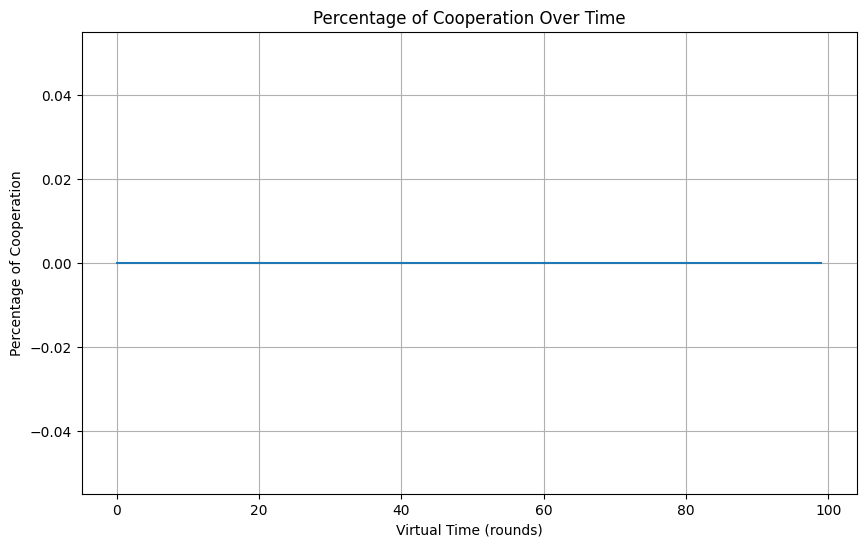

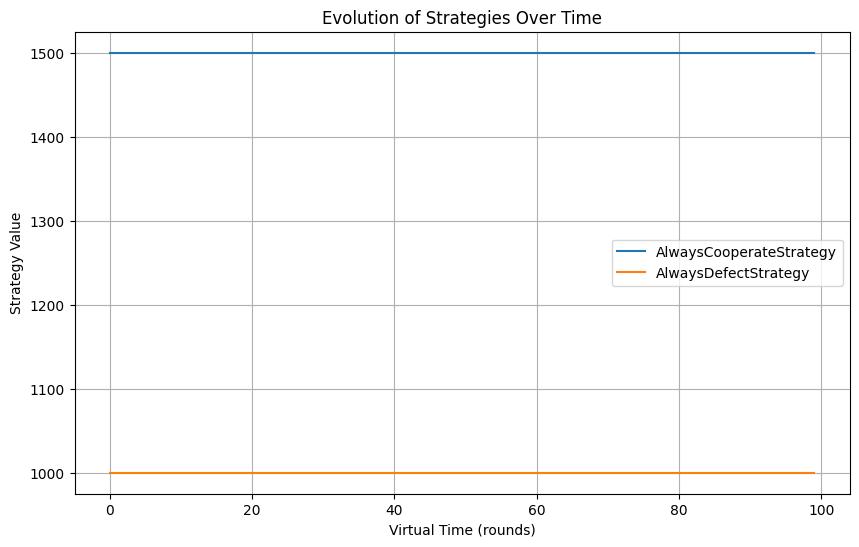

Text(0.5, 1.0, 'SoftMajor leads to random equilibrium around 50-50')

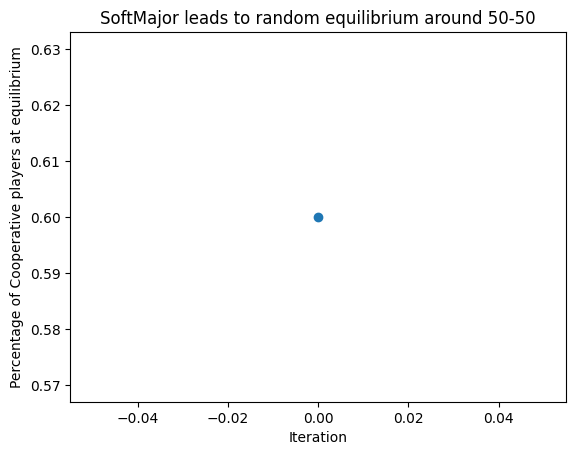

In [384]:
s.plot_cooperation(num_rounds)
dff = s.plot_evolution()

plt.scatter(np.arange(0,len(cooperate_dominance),1),cooperate_dominance)
plt.xlabel('Iteration')
plt.ylabel('Percentage of Cooperative players at equilibrium')
plt.title('SoftMajor leads to random equilibrium around 50-50')

# Tests

In [273]:
# print("Test CooperateUntilNDefectionsInARow")
# lattice = [
#     Player(
#         AlwaysCooperateStrategy(),
#         CooperateUntilNDefectionsInARow(n_defections_threshold=1),
#     ),
#     Player(AlwaysDefectStrategy(), NOPSwitcher()),
# ]
# assert lattice[0].strategy.__class__.__name__ == "AlwaysCooperateStrategy"
# play_game(lattice[0], lattice[1], 1)
# assert lattice[0].strategy.__class__.__name__ == "AlwaysDefectStrategy"
# print("Passed")

In [274]:
# print("Test CooperateUntilNDefectionsInARow (N = 1)")
# lattice = [
#     Player(AlwaysDefectStrategy(), NOPSwitcher()),
#     Player(
#         AlwaysCooperateStrategy(),
#         CooperateUntilNDefectionsInARow(n_defections_threshold=1),
#     ),
# ]
# assert lattice[1].strategy.__class__.__name__ == "AlwaysCooperateStrategy"
# play_game(lattice[0], lattice[1], 1)
# assert lattice[1].strategy.__class__.__name__ == "AlwaysDefectStrategy"
# print("Passed")

In [275]:
# print("Test CooperateUntilNDefectionsInARow (N = 2)")
# lattice = [
#     Player(
#         AlwaysCooperateStrategy(),
#         CooperateUntilNDefectionsInARow(n_defections_threshold=2),
#     ),
#     Player(AlwaysDefectStrategy(), NOPSwitcher()),
# ]
# assert lattice[0].strategy.__class__.__name__ == "AlwaysCooperateStrategy"
# play_game(lattice[0], lattice[1], 1)
# assert lattice[0].strategy.__class__.__name__ == "AlwaysCooperateStrategy"
# play_game(lattice[0], lattice[1], 1)
# assert lattice[0].strategy.__class__.__name__ == "AlwaysDefectStrategy"
# print("Passed")

In [276]:
# print("Test TitForTat")
# opponent_moves = ["C", "D", "D", "C", "C", "D"]
# lattice = [
#     Player(AlwaysCooperateStrategy(), TitForTat()),
#     Player(ListRepeatedStrategy(opponent_moves), NOPSwitcher()),
# ]

# for i in range(len(opponent_moves)):
#     expected_strategy_before = (
#         "AlwaysDefectStrategy"
#         if i - 1 >= 0 and opponent_moves[i - 1] == "D"
#         else "AlwaysCooperateStrategy"
#     )
#     assert lattice[0].strategy.__class__.__name__ == expected_strategy_before
#     play_game(lattice[0], lattice[1], 1, offset=i)
#     expected_strategy_after = (
#         "AlwaysDefectStrategy"
#         if opponent_moves[i] == "D"
#         else "AlwaysCooperateStrategy"
#     )
#     assert lattice[0].strategy.__class__.__name__ == expected_strategy_after
# print("Passed")

In [277]:
# print("Test RetaliateWithTwoDefections")
# expected_moves = ["C", "C", "D", "D", "C", "C", "D", "D", "D", "D", "C", "C"]
# opponent_moves = ["C", "D", "C", "C", "C", "D", "D", "C", "C", "C", "C", "C"]
# lattice = [
#     Player(AlwaysCooperateStrategy(), RetaliateWithTwoDefections()),
#     Player(ListRepeatedStrategy(opponent_moves), NOPSwitcher()),
# ]

# for i in range(len(opponent_moves)):
#     expected_strategy_before = (
#         "AlwaysDefectStrategy"
#         if expected_moves[i] == "D"
#         else "AlwaysCooperateStrategy"
#     )
#     assert lattice[0].strategy.__class__.__name__ == expected_strategy_before
#     play_game(lattice[0], lattice[1], 1, offset=i)
# print("Passed")